In [1]:
import mxnet as mx
import gluonnlp as nlp
import numpy as np
import pandas as pd

from tqdm import tqdm

In [2]:
w2v = nlp.embedding.Word2Vec()

In [3]:
nlp.embedding.list_sources('Word2Vec')

['GoogleNews-vectors-negative300',
 'freebase-vectors-skipgram1000-en',
 'freebase-vectors-skipgram1000']

In [4]:
len(w2v["man"])

300

In [6]:
headlines = pd.read_csv('abcnews-date-text.csv',parse_dates=[0], infer_datetime_format=True)

In [7]:
headlines.head()

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


In [41]:
import re
import string

# Cleaning the corpus
def clean_text(text):
    """
    Makes text lowercase for better comparison.
    Removes punctuation, trailing characters, text between
    square brackets, words containing numbers and links.
    Similar function to the one built for Chapter 2, Recipe 4
    """
    text = str(text).lower()
    text = re.sub("\[.*?\']", '', text)
    text = re.sub("https?://\S+|www\.\S+", '', text)
    text = re.sub("<.*?>+", '', text)
    text = re.sub("[%s]" % re.escape(string.punctuation), '', text)
    text = re.sub("\n", ' ', text)
    text = re.sub("\w*\d\w*", '', text)
    # No emails, so word subject can be interesting and is not removed
    # text = re.sub("subject", '', text)
    text = re.sub("\\r", ' ', text)
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    for p in punct:
        text = text.replace(p, '')
    return text

headlines["headline_text"] = headlines["headline_text"].apply(clean_text)
# # This deletes short words (2 characters or less)
headlines['headline_text'] = headlines['headline_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

headlines.head()

In [42]:
number_headlines = len(headlines)
print(number_headlines)

1226258


In [43]:
reduced_number_headlines = int(0.05 * number_headlines)
print(reduced_number_headlines)

61312


In [44]:
# Test 1st 2 words of 1st headline: "aba decides ..."
print(w2v["aba"][:5])
print(w2v["decides"][:5])
print(w2v["against"][:5])

concat_array = mx.nd.concat(w2v["aba"].reshape(1, 300), w2v["decides"].reshape(1, 300), w2v["against"].reshape(1, 300), dim=0)
mx.nd.mean(concat_array, axis=0)[:5]


[0.034043 0.038907 0.018783 0.044944 0.037397]
<NDArray 5 @cpu(0)>

[ 0.065388  0.064402  0.077874  0.013472 -0.026287]
<NDArray 5 @cpu(0)>

[ 0.013913  0.108777  0.112993 -0.089383  0.045324]
<NDArray 5 @cpu(0)>



[ 0.03778133  0.07069533  0.06988334 -0.01032233  0.01881133]
<NDArray 5 @cpu(0)>

In [45]:
# Pre-processing
# MXNet pre-trained model works with 300 embedding features
embedding_features = 300

# This is a very time-consuming process
average_embeddings_headlines = mx.nd.empty((reduced_number_headlines, embedding_features))

for index, headline in tqdm(enumerate(headlines["headline_text"][:reduced_number_headlines]), total=reduced_number_headlines):
    bag_of_words = headline.split()
    number_of_words = len(bag_of_words)
    
    # Process 1st word (to be able to concatenate)
    word_embeddings_array = w2v[bag_of_words[0]].reshape(1, embedding_features)
    
    for word in bag_of_words[1:]:
        word_embeddings = w2v[word].reshape(1, embedding_features)
        word_embeddings_array = mx.nd.concat(word_embeddings_array, word_embeddings, dim=0)
    
    average_embedding_headline = mx.nd.mean(word_embeddings_array, axis=0)
    average_embeddings_headlines[index] = average_embedding_headline

100%|████████████████████████████████████| 61312/61312 [02:40<00:00, 382.90it/s]


In [46]:
len(average_embeddings_headlines)

61312

In [47]:
average_embeddings_headlines[0].shape

(300,)

In [82]:
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=4, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(average_embeddings_headlines.asnumpy())

In [83]:
df = pd.DataFrame({"headlines": headlines.headline_text[0:len(average_embeddings_headlines)], "topic_cluster": y_km})

In [84]:
df.head()

,headlines,topic_cluster
0,aba decides against community broadcasting lic...,3
1,act fire witnesses must aware defamation,0
2,calls for infrastructure protection summit,2
3,air staff aust strike for pay rise,2
4,air strike affect australian travellers,3


In [85]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=10):
  vec = CountVectorizer(stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

In [100]:
import matplotlib.pyplot as plt

words = []
word_values = []
cluster = 3
indexes_cluster = (df["topic_cluster"] == cluster)

df[indexes_cluster].head()

,headlines,topic_cluster
0,aba decides against community broadcasting lic...,3
4,air strike affect australian travellers,3
9,australia locked into war timetable opp,3
10,australia contribute million aid iraq,3
11,barca take record robson celebrates birthday,3


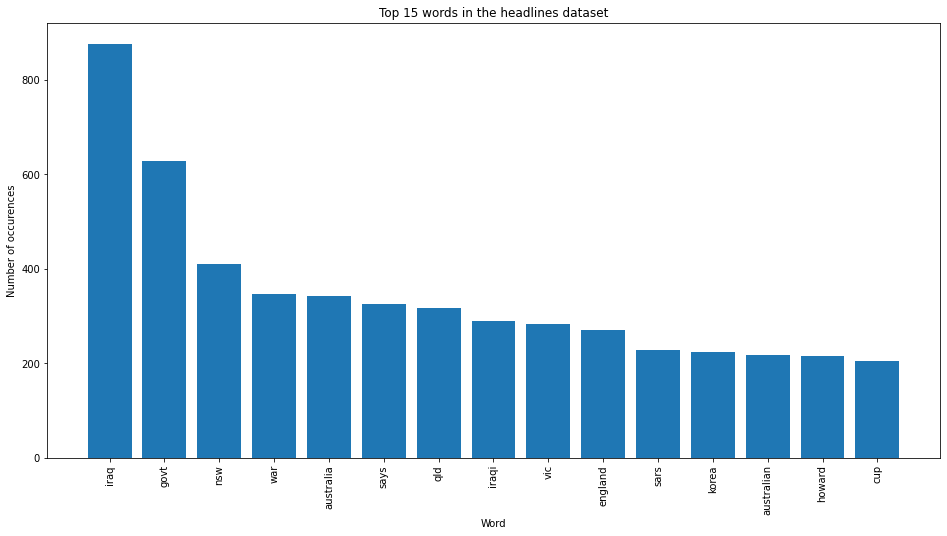

In [101]:
for i,j in get_top_n_words(df[indexes_cluster]["headlines"], 15):
  words.append(i)
  word_values.append(j)
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 15 words in the headlines dataset');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [102]:
# Apply stop-words, stemming, lemmatization to all words

import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

stemmer = nltk.stem.snowball.EnglishStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package punkt to /home/andres/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/andres/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/andres/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [103]:
# Stop Words
stop_words = set(nltk.corpus.stopwords.words("english"))

In [105]:
def process_words(
    text,
    stop_words=stop_words,
    stemmer = stemmer,
    lemmatizer = lemmatizer):
    
    words = nltk.tokenize.word_tokenize(text)
       
    filtered_words_pre = []
    filtered_words_post = []
    
    for word in words:
        
        if word not in stop_words and word.isalpha():
            filtered_words_pre.append(word)
            word = stemmer.stem(word)
            filtered_words_post.append(lemmatizer.lemmatize(word))
    
    return filtered_words_post

In [106]:
headlines["headline_text_post"] = headlines["headline_text"].apply(process_words)

In [107]:
headlines.head()

,publish_date,headline_text,headline_text_post
0,2003-02-19,aba decides against community broadcasting lic...,"[aba, decid, communiti, broadcast, licenc]"
1,2003-02-19,act fire witnesses must aware defamation,"[act, fire, wit, must, awar, defam]"
2,2003-02-19,calls for infrastructure protection summit,"[call, infrastructur, protect, summit]"
3,2003-02-19,air staff aust strike for pay rise,"[air, staff, aust, strike, pay, rise]"
4,2003-02-19,air strike affect australian travellers,"[air, strike, affect, australian, travel]"


In [111]:
# This is a very time-consuming process
average_embeddings_headlines = mx.nd.empty((reduced_number_headlines, embedding_features))

for index, bag_of_words in tqdm(enumerate(headlines["headline_text_post"][:reduced_number_headlines]), total=reduced_number_headlines):
    number_of_words = len(bag_of_words)
    
    # Process 1st word (to be able to concatenate)
    word_embeddings_array = w2v[bag_of_words[0]].reshape(1, embedding_features)
    
    for word in bag_of_words[1:]:
        word_embeddings = w2v[word].reshape(1, embedding_features)
        word_embeddings_array = mx.nd.concat(word_embeddings_array, word_embeddings, dim=0)
    
    averate_embedding_headline = mx.nd.mean(word_embeddings_array, axis=0)
    average_embeddings_headlines[index] = averate_embedding_headline

100%|████████████████████████████████████| 61312/61312 [02:29<00:00, 410.78it/s]


In [112]:
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=4, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(average_embeddings_headlines.asnumpy())

In [113]:
df = pd.DataFrame({"headlines": headlines.headline_text[0:len(average_embeddings_headlines)], "topic_cluster": y_km})

In [114]:
df.head()

,headlines,topic_cluster
0,aba decides against community broadcasting lic...,0
1,act fire witnesses must aware defamation,1
2,calls for infrastructure protection summit,1
3,air staff aust strike for pay rise,1
4,air strike affect australian travellers,1


In [115]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=10):
  vec = CountVectorizer(stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

In [125]:
import matplotlib.pyplot as plt

words = []
word_values = []
cluster = 3
indexes_cluster = (df["topic_cluster"] == cluster)

df[indexes_cluster].head()

,headlines,topic_cluster
5,ambitious olsson wins triple jump,3
6,antic delighted with record breaking barca,3
13,big hopes for launceston cycling championship,3
18,bryant leads lakers double overtime win,3
21,calleri avenges final defeat eliminate massu,3


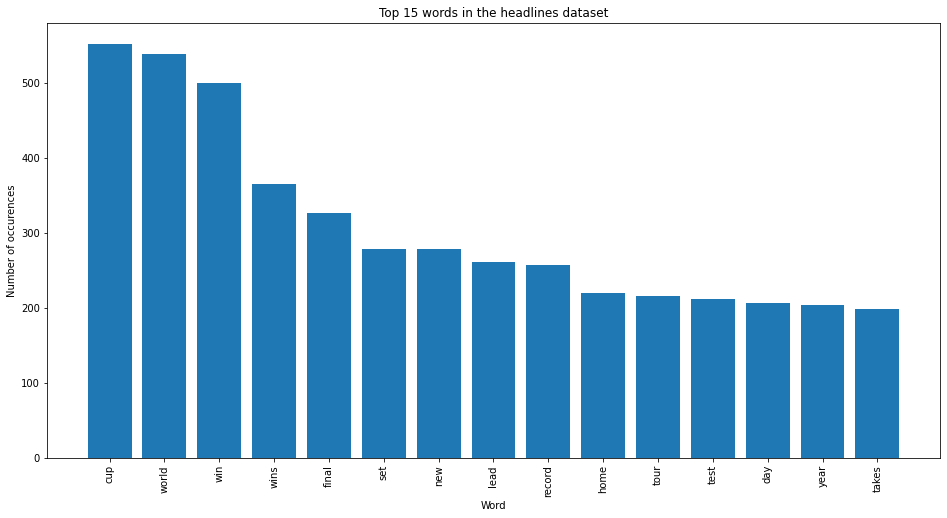

In [126]:
for i,j in get_top_n_words(df[indexes_cluster]["headlines"], 15):
  words.append(i)
  word_values.append(j)
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 15 words in the headlines dataset');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()